<p><img src="https://github.com/profLewis/Geog2021_Coursework/blob/master/images/ucl_logo.png?raw=true" align="left" \><img src="https://www.nceo.ac.uk/wp-content/themes/nceo/assets/images/logos/img_logo_purple.svg" align="right" /></p>

# Quick visualisation and analysis of Sentinel 2 data over Colombia
### J Gómez-Dans (NCEO & UCL)

This notebook presents a quick way to extract and analyse data from Sentinel 2. This is just a demo that highlights a limited regional extent around the town of Aguadas, but this could be extended to other areas.

The notebooks shows how the user can select a region of interest (ROI) online, using e.g. [GeoJSON.io](https://geojson.io), or [Google My Maps](https://www.google.com/mymaps), or any other way you want. You will then extract all the data that pertains to that region of interest and you can play around with it in normal Python.

Note that all the data is being accessed remotely, so it can take a little while for the code to complete. However, note that you are only downloading the bits that you require to process your data! It's around 150Gb of raw data that needs downloading and processing!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import gdal
gdal.UseExceptions()   

from utils import grab_holdings, extract_roi_data_ndre

img_db = grab_holdings(
    url="http://www2.geog.ucl.ac.uk/~ucfajlg/Colombia/database.json")
print(f"First acquisition: {list(img_db.keys())[0].strftime('%d %b %Y'):s}")
print(f"Last acquisition: {list(img_db.keys())[-1].strftime('%d %b %Y'):s}")
print(f"Total number of acquisitions: {len(img_db.keys()):d}, although there might be clouds!")

First acquisition: 02 Jan 2018
Last acquisition: 30 Dec 2018
Total number of acquisitions: 115, although there might be clouds!


/home/ucfajlg/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


The previous cell has obtained a listing of all the dates in which we have data available remotely. The data covers an area of arond 100 x 100 km around Aguadas, and we have nearly all the Sentinel 2 acquisitions from 2018 (there are quite a few!). Suppose you want to examine a small region defined by [this box](https://gist.github.com/jgomezdans/bf202f1f0028c454ccc1ba85443414cb/) (you may need to zoom out to actually see the location). We want to extract the data over that location. In this case, we'll extract a vegetation index, but obviously there's a lot more flexibility. We can just point to the remote file, or you can also upload a shapefile, KML, geojson file here and change `roi` to its filename.

When you run the following cell, the data will be downloaded and extracted, returning a Python dictionary that stores the dates and the vegetation index.

In [2]:
roi="https://gist.github.com/jgomezdans/bf202f1f0028c454ccc1ba85443414cb/raw" + \
    "/e25580e4afb2402532619ce196494eb907472708/aguadas.geojson"
analysis_data = extract_roi_data_ndre(img_db, roi=roi)

/home/ucfajlg/python/demo_colombia/utils.py:49: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(data1)):


This has taken a while. This is because all the data has been streamed from UCL's servers, as no data is stored locally. We will now just plot the vegetation index as an image. `analysis_data` is a dictionary, where the key is the data of the acquisition and the item itself is a 2D subset that matches the ROI provided earlier.

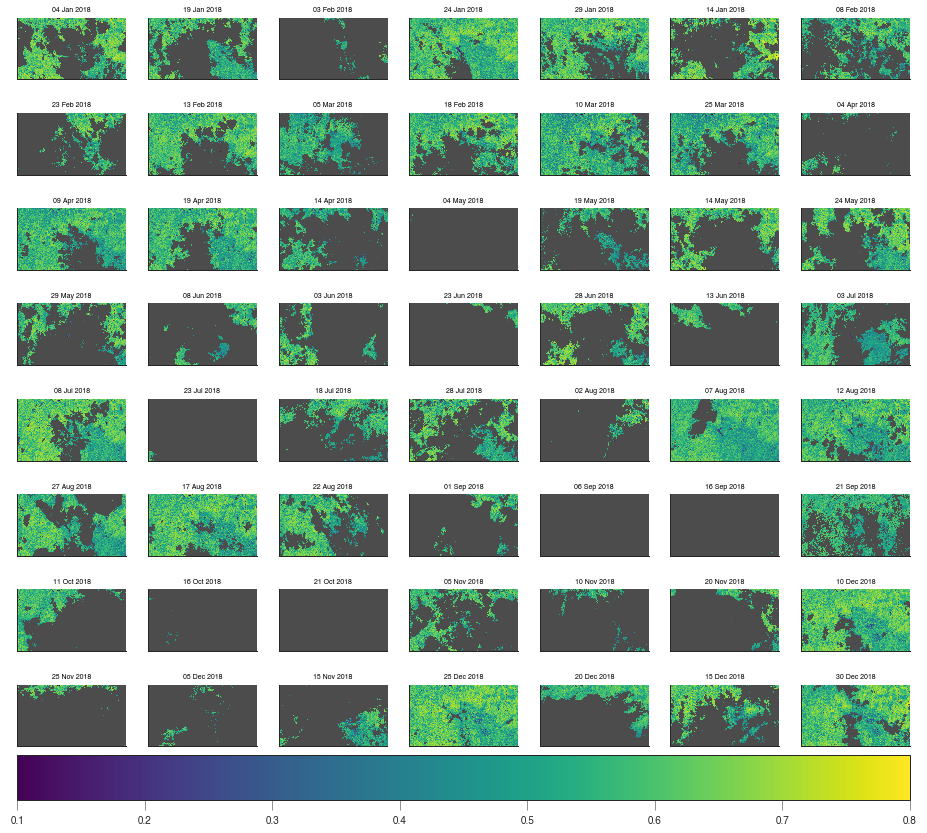

In [17]:
len(analysis_data)
fig, axs = plt.subplots(nrows=8, ncols=7, sharex=True, sharey=True, figsize=(16,16))
axs = axs.flatten()
cmap=plt.cm.viridis
cmap.set_bad("0.3")
for ii, (k,v) in enumerate(analysis_data.items()):
    im =axs[ii].imshow(v, interpolation="nearest", vmin=0.1, vmax=0.8, )
    axs[ii].set_title(k.strftime("%d %b %Y"), fontsize=7)
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])

fig.colorbar(im, ax=axs.tolist(), orientation="horizontal", pad=0.01)



There is clearly some data, although there is a lot of cloud too. We have used a fairly strict cloud mask, so maybe it's filter too much, but it's worth noting that cloud shadows will also be a problem.

We can now plot a boxplot of the index distribution. 

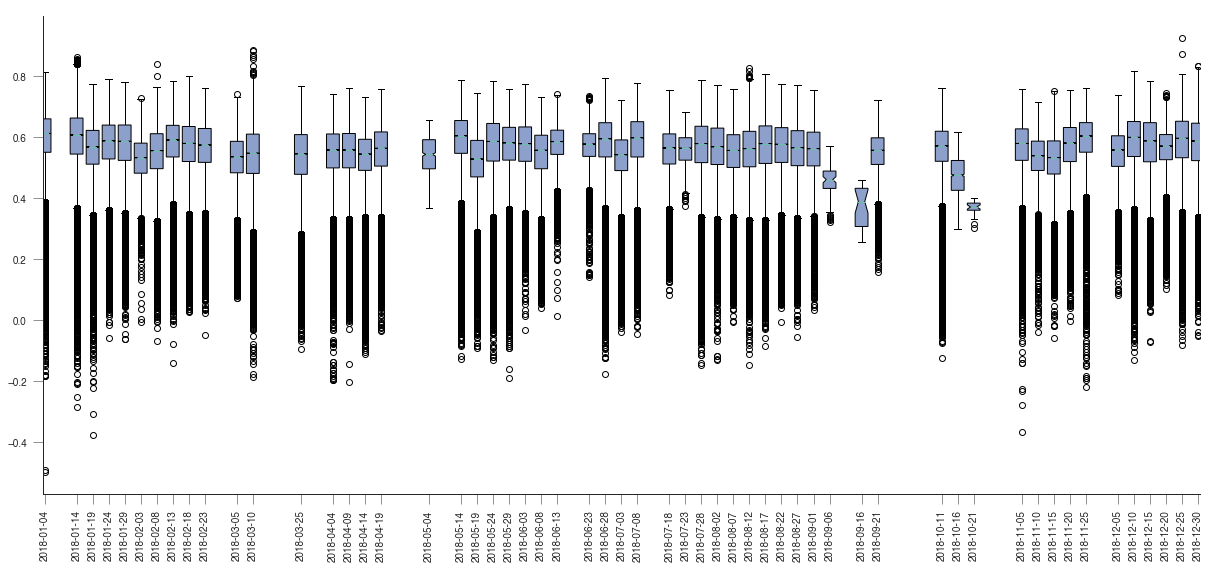

In [22]:
data = []
doys = []
tx = []
for ii, (k,v) in enumerate(analysis_data.items()):
    tx.append(k)
    doys.append(int(k.strftime("%j")))
    mask = np.isfinite(v.flatten())
    data.append(v.flatten()[mask])
isort = np.argsort(tx)
doys = [doys[i] for i in isort]
tx = [tx[i] for i in isort]
data = [data[i] for i in isort]
plt.figure(figsize=(17,8))    
bp = plt.boxplot(data, positions=doys, notch=True, widths=4,
                 meanline=True, patch_artist=True, labels=tx)
_ = plt.xticks(rotation="vertical")
_ = [patch.set_facecolor("#8DA0CB") for patch in bp['boxes']]
plt.tight_layout()

Not particularly interesting! We get a pretty flat mean hovering around 0.5-0.6 over the whole year.